In [1]:
import numpy as np
import pandas as pd
import torch 
import scipy
import time


In [2]:
device = torch.device('cpu')

# Load the trained model from local file

In [3]:
import sys
sys.path.append('../')  # Add the parent directory to the Python path

from torch_NN.nn import ResNN_pricing

hyperparas = {'input_dim':5,'hidden_dim':64,'hidden_nums':10,'output_dim':88,'block_layer_nums':3}

model = ResNN_pricing(hyperparas=hyperparas).to(device=device,dtype=torch.float64)

model_state = torch.load('../Data/YU/res_layernorm_Heston.pth')

model.load_state_dict(model_state)

model.eval()

ResNN_pricing(
  (linear_stock): Sequential(
    (0): Sequential(
      (0): Linear(in_features=5, out_features=64, bias=True)
      (1): ReLU()
    )
    (1): ResNetBlock(
      (layers): ModuleList(
        (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
      )
      (layernorms): ModuleList(
        (0-1): 2 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (2): ResNetBlock(
      (layers): ModuleList(
        (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
      )
      (layernorms): ModuleList(
        (0-1): 2 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (3): ResNetBlock(
      (layers): ModuleList(
        (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
      )
      (layernorms): ModuleList(
        (0-1): 2 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (4): ResNetBlock(
      (layers): ModuleList(
        (0-1): 2 x Linear(in_features=64, out_features=64, bi

# load the test dataset

In [4]:
import gzip
f = gzip.GzipFile('../Data/HestonTrainSet.txt.gz', "r")
dat=np.load(f)
xx=dat[:,:5]
yy=dat[:,5:]

strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x_train, x_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)
scale_x = StandardScaler()
scale_y=  StandardScaler()

def xtransform(x_train, x_test):
    return [scale_x.fit_transform(x_train),scale_x.transform(x_test)]

def xinversetransform(x):
    return scale_x.inverse_transform(x)

def ytransform(y_train,y_test):
    return [scale_y.fit_transform(y_train),scale_y.transform(y_test)]

def yinversetransform(y):
    return scale_y.inverse_transform(y)



ub=np.array([0.04,-0.1,1.0,0.2,10.0])
lb=np.array([0.0001,-0.95,0.01,0.01,1])
def myscale(x):
    return (x - (ub+lb)*0.5)*2/(ub-lb)
def myinverse(x):
    return x*(ub-lb)*0.5+(ub+lb)*0.5

x_train_transform = myscale(x_train)
x_test_transform = myscale(x_test)
[y_train_transform,y_test_transform] = ytransform(y_train,y_test)

test_data = (torch.from_numpy(x_test_transform).to(device=device),torch.from_numpy(y_test_transform).to(device=device))

# use 3 different optimization algorithm in scipy.optimize:

"L-BFGS-B ","SLSQP","BFGS"

In [6]:
def CostFunc(x,sample_ind):
    return np.sum(np.power((model(torch.from_numpy(x)).detach().numpy()
                            -y_test_transform[sample_ind]),2))


import time
import scipy
Approx=[]
Timing=[]
solutions=np.zeros([3,5])
times=np.zeros(3)
init=np.zeros(5)
for i in range(1800):
    disp=str(i+1)+"/1800"
    print (disp,end="\r")
    #L-BFGS-B
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='L-BFGS-B',tol=1E-10,options={"maxiter":10000})
    end= time.time()
    solutions[0,:]=myinverse(I.x)
    times[0]=end-start
    #SLSQP
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='SLSQP',tol=1E-10,options={"maxiter":10000})
    end= time.time()
    solutions[1,:]=myinverse(I.x)
    times[1]=end-start
    #BFGS
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='BFGS',tol=1E-10,options={"maxiter":10000})
    end= time.time()
    solutions[2,:]=myinverse(I.x)
    times[2]=end-start
    Approx.append(np.copy(solutions))
    Timing.append(np.copy(times))

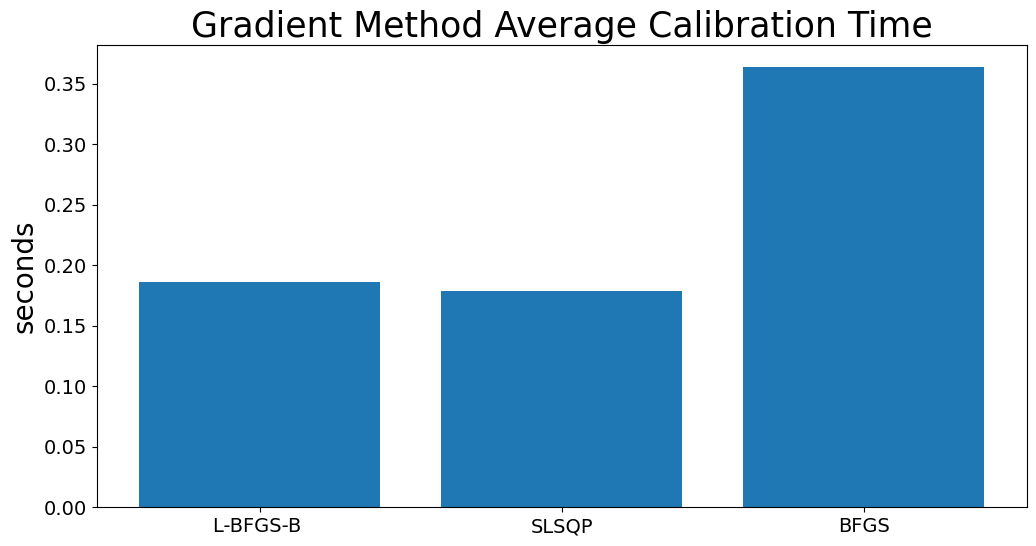

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

methods=["L-BFGS-B ","SLSQP","BFGS"]
plt.figure(1,figsize=(12,6))
plt.bar(methods,np.mean(Timing,axis=0))
plt.title("Gradient Method Average Calibration Time",fontsize=25)
plt.ylabel("seconds",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

In [8]:
LMParameters=[Approx[i][1] for i in range(len(Approx))]
np.savetxt("../Data/YU/NNParametersHeston.txt",LMParameters)
LMParameters = np.loadtxt("../Data/YU/NNParametersHeston.txt")

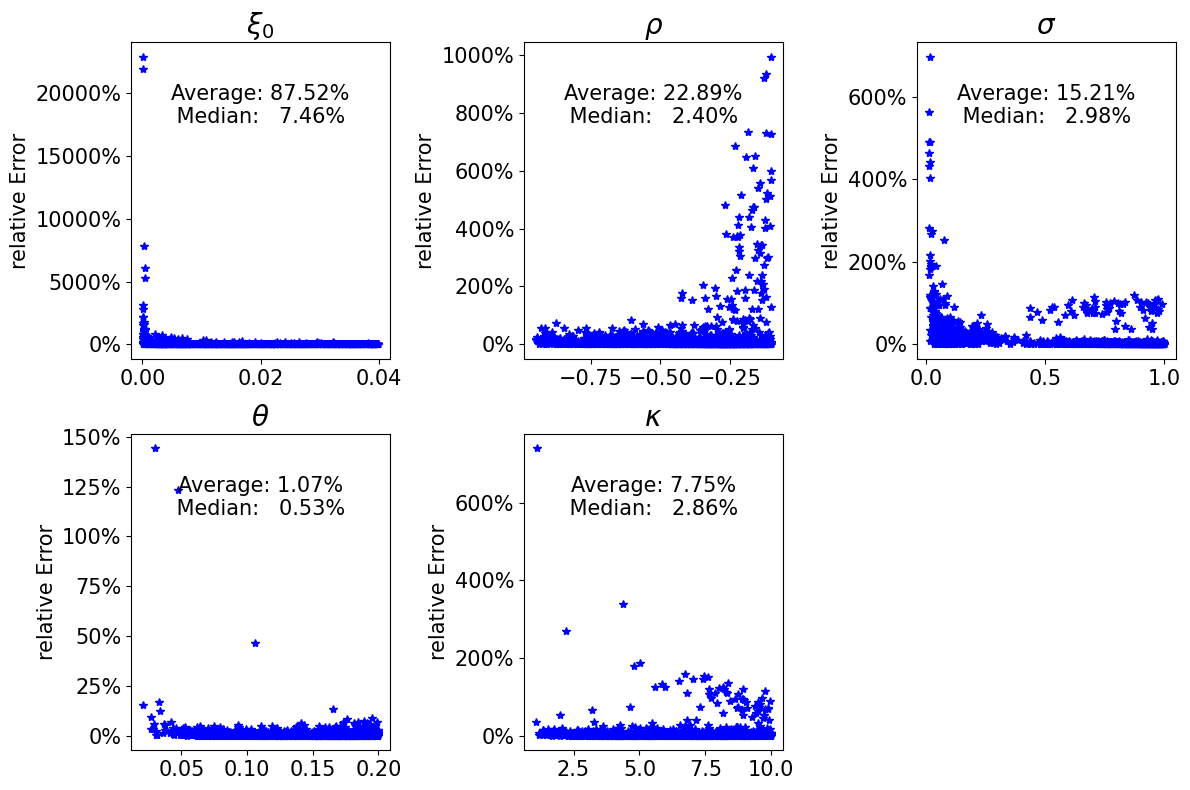

In [9]:
titles=["$\\xi_0$","$\\rho$","$\\sigma$","$\\theta$", "$\\kappa$"]
average=np.zeros([5,1800])
fig=plt.figure(figsize=(12,8))
for u in range(5):
    ax=plt.subplot(2,3,u+1)
    x=x_test[:1800,u]
    plt.plot(x,100*np.abs(LMParameters[:1800,u]-x)/np.abs(x),'b*')
    average[u,:]=np.abs(LMParameters[:1800,u]-x)/np.abs(x)
    
    plt.title(titles[u],fontsize=20)
    plt.ylabel('relative Error',fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(100*average[u,:]),np.quantile(100*average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
plt.tight_layout()

plt.savefig('HestonParameterRelativeErrors.png', dpi=300)
plt.show();

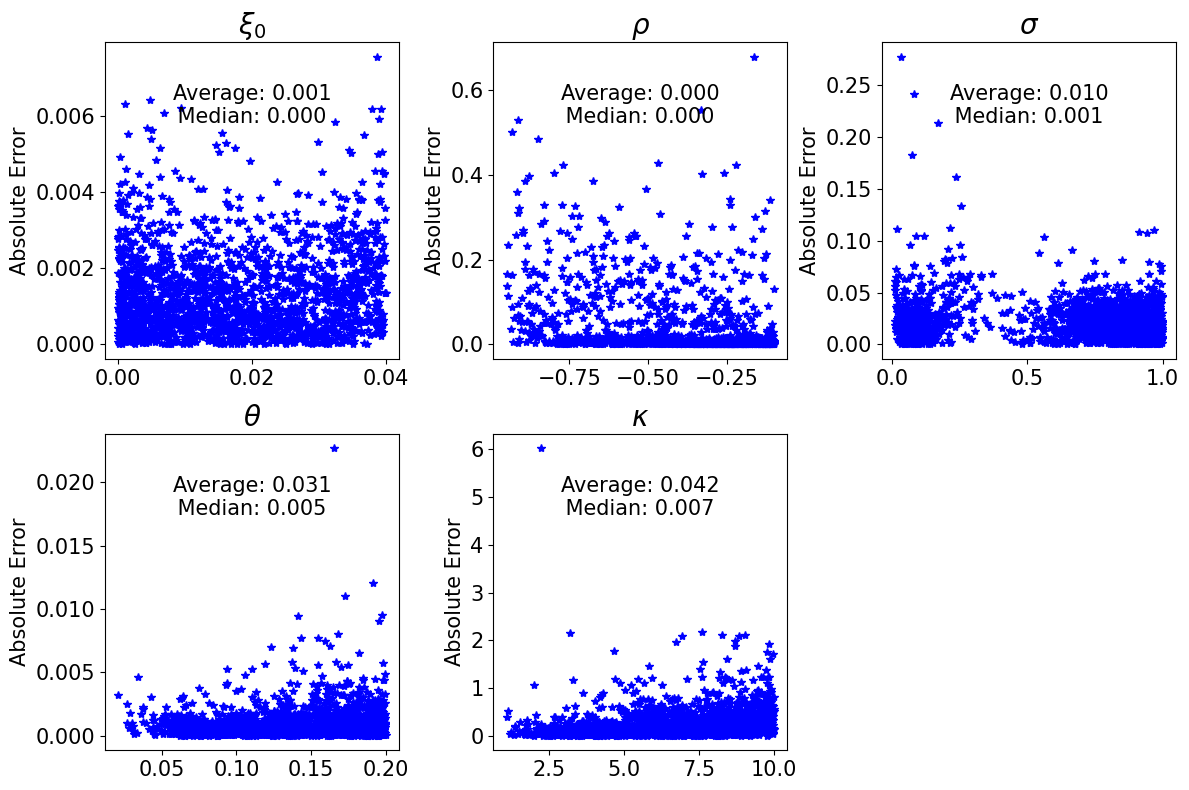

In [22]:
titles=["$\\xi_0$","$\\rho$","$\\sigma$","$\\theta$", "$\\kappa$"]
average=np.zeros([1800,5])
fig=plt.figure(figsize=(12,8))
for u in range(5):
    ax=plt.subplot(2,3,u+1)
    x=x_test[:,u]
    plt.plot(x,np.abs(LMParameters[:,u]-x),'b*')
    average[:,u]=np.abs(LMParameters[:,u]-x)
    
    plt.title(titles[u],fontsize=20)
    plt.ylabel('Absolute Error',fontsize=15)
    
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, f'Average: {np.mean(average[u,:]):.3f}\n Median: {np.median(average[u,:]):.3f} ',
              horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
plt.tight_layout()

plt.savefig('HestonParameterAbsoluteErrors.png', dpi=300)
plt.show()

In [11]:
Approx_2=[]
Timing_2=[]

for i in range(1800):
    solutions = np.zeros((5,))

    disp=str(i+1)+"/1800"
    print (disp,end="\r")
    #L-BFGS-B
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method="L-BFGS-B",tol=1E-12,options={"maxiter":50000})
    end= time.time()
    solutions=myinverse(I.x)
    times=end-start

    Approx_2.append(np.copy(solutions))
    Timing_2.append(times)

In [12]:
print(f"avarage calibration time: {np.mean(Timing_2)}s" )

avarage calibration time: 0.20214338329103257s


In [13]:
LMParameters=[Approx_2[i] for i in range(len(Approx))]
np.savetxt("../Data/YU/NNParametersHeston_L-BFGS-B.txt",LMParameters)
LMParameters = np.loadtxt("../Data/YU/NNParametersHeston_L-BFGS-B.txt")

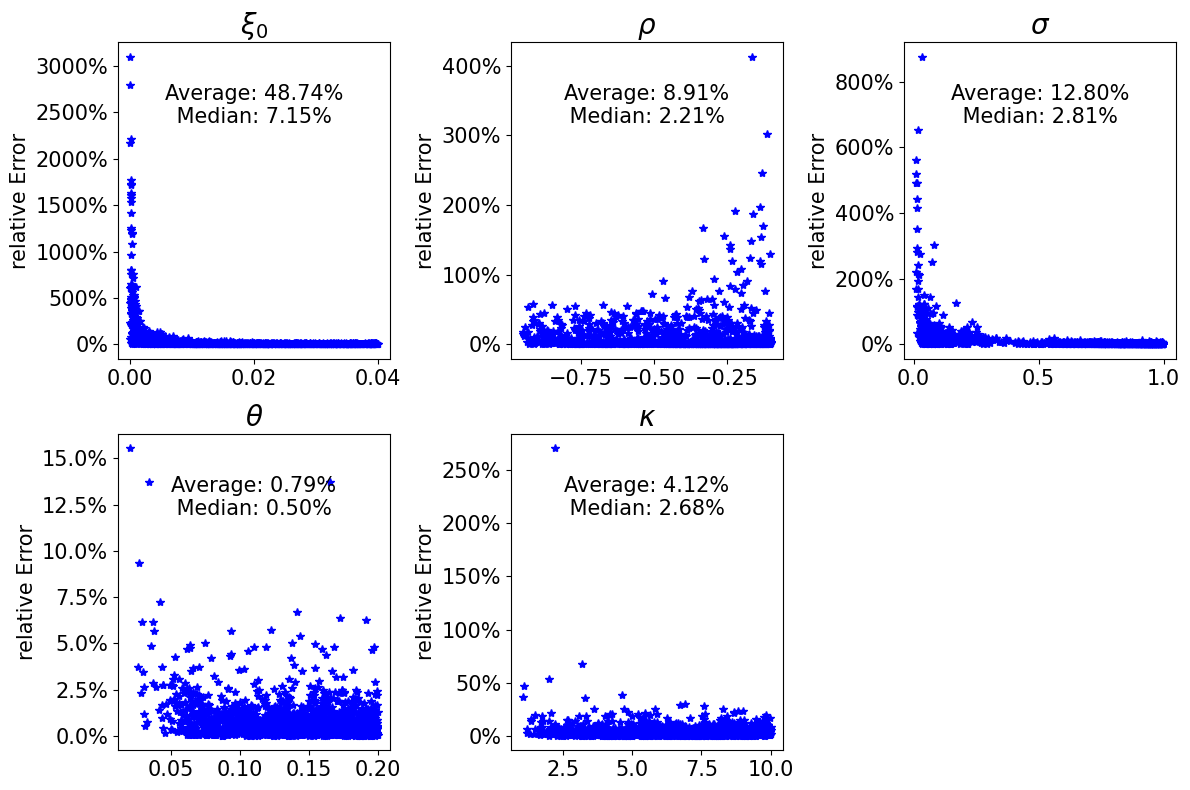

In [19]:
titles=["$\\xi_0$","$\\rho$","$\\sigma$","$\\theta$", "$\\kappa$"]
average=np.zeros([5,1800])
fig=plt.figure(figsize=(12,8))
for u in range(5):
    ax=plt.subplot(2,3,u+1)
    x=x_test[:1800,u]
    plt.plot(x,100*np.abs(LMParameters[:1800,u]-x)/np.abs(x),'b*')
    average[u,:]=np.abs(LMParameters[:1800,u]-x)/np.abs(x)
    
    plt.title(titles[u],fontsize=20)
    plt.ylabel('relative Error',fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, f'Average: {100*np.mean(average[u,:]):.2f}%\n Median: {100*np.median(average[u,:]):.2f}% ' 
             , horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
plt.tight_layout()

plt.savefig('HestonParameterRelativeErrors.png', dpi=300)
plt.show()

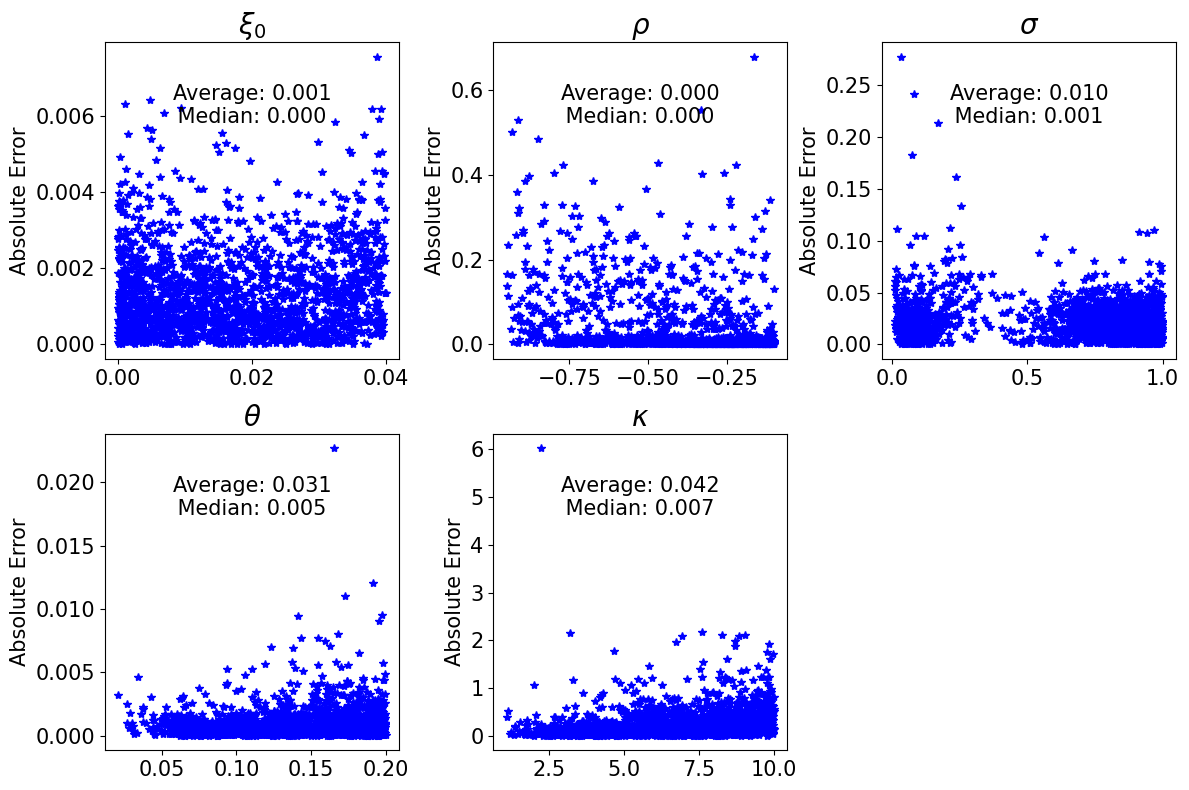

In [21]:
titles=["$\\xi_0$","$\\rho$","$\\sigma$","$\\theta$", "$\\kappa$"]
average=np.zeros([1800,5])
fig=plt.figure(figsize=(12,8))
for u in range(5):
    ax=plt.subplot(2,3,u+1)
    x=x_test[:,u]
    plt.plot(x,np.abs(LMParameters[:,u]-x),'b*')
    average[:,u]=np.abs(LMParameters[:,u]-x)
    
    plt.title(titles[u],fontsize=20)
    plt.ylabel('Absolute Error',fontsize=15)
    
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, f'Average: {np.mean(average[u,:]):.3f}\n Median: {np.median(average[u,:]):.3f} ', 
             horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
plt.tight_layout()

plt.savefig('HestonParameterAbsoluteErrors.png', dpi=300)
plt.show()